In [8]:
from preprocess.pipelinesV2 import build_pipeline, build_coco_pipeline
import tensorflow as tf
import re
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import textwrap
import json
import pandas as pd
import os
import pickle
# Tokenizers
from tokenizers.tokenizers import KerasTokenizer
# Model
from models.CaptioningTransformer import CaptioningTransformer
from models.Callbacks import CaptioningCallback
from models.model_utils import load_captioning_model
# Results
from results.CaptioningFunctions import predict_caption, caption_dataset


# Setup saving path for the model 

In [2]:
# Setup Callbacks--------------------------------------------------------------------------
# Define checkpoints path
date_str=datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # Get the date/ model name
save_model_path='../models/' + date_str # build savepath

# Define logs path
log_dir='../model_logs/pretraining/captioning/'+date_str # The logs directory

# Obtain and tokenize data

In [3]:
# Load data
data=build_coco_pipeline()
# Setup configuration-----------------------------------------------------------------
config={
    'model_name':date_str,
    'seq_len':178,
    'num_heads':1,
    'model_dim':100,
    'dropout':0.2,
    'img_backbone_trainable':False,
    'img_size':(299,299,3),
    'img_backbone':'efficientnetb0',
    'intermediate_size':100*4,
    'vocab_size':None,
    'capts_per_img':5,
    'num_encoder_blocks':3,
    'num_decoder_blocks':3,
}
# Tokenize-------------------------------------------------------------------------------------
# Get the training texts
tokenizer_data=data['captioning']['train_captions'].take(10)

# Initialize tokenizer
tokenizer=KerasTokenizer(seq_len=config['seq_len'])
tokenizer.build_vocabulary(tokenizer_data)
config['vocab_size']=tokenizer.vocab_size

# Tokenize dataset
# Add tokenizing step to pipeline
def tokenize(ds_row):
    tokens=tokenizer.tokenize(ds_row['text'])
    return {'image':ds_row['image'],
           'text':ds_row['text'],
           'tokens':tokens}
batch_size=32
# Obtain data for training, validation and test 
train_data = data['captioning']['train'].map(tokenize,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)
val_data = data['captioning']['val'].map(tokenize,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)
test_data = data['captioning']['test'].map(tokenize,num_parallel_calls=tf.data.AUTOTUNE)

# Save tokenizer vocabulary
tokenizer.save_vocabulary(model_name=config['model_name'])


Loading coco...
remember coco dataset has 5 captions per image so  the value for the "text" key will be a (5,) string array.


2023-01-26 06:01:48.002439: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-26 06:01:48.002601: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-8-20221025-075908): /proc/driver/nvidia/version does not exist
2023-01-26 06:01:48.009513: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Setup Callbacks

In [4]:
# Define callbacks

# Since model is subclassed we save weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( # Callback to save the model every epoch end
        filepath=save_model_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

tensorboard_callback=tf.keras.callbacks.TensorBoard(  # Callback to log loss and accuracy every epoch
    log_dir=log_dir,
    histogram_freq=None,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=1,
    embeddings_metadata=None)

# monitor: Quantity to be monitored.
# min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
#            change of less than min_delta, will count as no improvement.
# patience: Number of epochs with no improvement after which training will be stopped.
# verbose: Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
# mode: One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped 
#       decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" 
#       mode, the direction is automatically inferred from the name of the monitored quantity.
# baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement
#           over the baseline.
# restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored 
#                       quantity. If False, the model weights obtained at the last step of training are used.
#                       An epoch will be restored regardless of the performance relative to the baseline. If 
#                       no epoch improves on baseline, training will run for patience epochs and restore weights 
#                       from the best epoch in that set.
# start_from_epoch: Number of epochs to wait before starting to monitor improvement. This allows for a warm-up 
#                   period in which no improvement is expected and thus training will not be stopped.

early_stopping_callback=tf.keras.callbacks.EarlyStopping(
                                                            monitor="val_loss",
                                                            min_delta=.001,
                                                            patience=3,
                                                            verbose=1,
                                                            mode="min",
                                                            baseline=None,
                                                            restore_best_weights=True,
                                                            start_from_epoch=0,
                                                         )

captioning_callback= CaptioningCallback(config=config,
                                       log_dir=log_dir)



# Instantiate and train model

In [5]:
# Train the model
model= CaptioningTransformer(config)
loss=tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',from_logits=False)
opt = tf.keras.optimizers.Adam()
# opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss=loss, optimizer=opt)

model.fit(train_data.take(1),validation_data=val_data.take(1),epochs=1,callbacks=[checkpoint_callback,
                                                                           tensorboard_callback,
                                                                            early_stopping,
                                                                           captioning_callback])

1/1 [==============================] - 196s 196s/step - loss: 20.7184 - acc: 0.2781 - val_loss: 14.4932 - val_acc: 0.4604


# Evaluate model

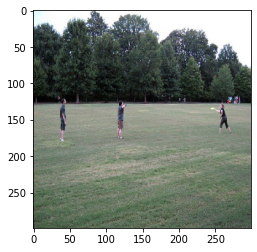

a [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [U

KeyboardInterrupt: 

In [10]:
caption_dataset(test_data.take(1),model,tokenizer)

# Load a model and its tokenizer's vocab

In [14]:
model_name='20230126-060147'
model=load_captioning_model(model_name)

tokenizer=KerasTokenizer(seq_len=model.config['seq_len'])
tokenizer.load_vocabulary(model_name)

1/1 [==============================] - 7s 7s/step - loss: 27.8507 - acc: 0.0068
